In [3]:
from prophet import Prophet
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import pmdarima as pmd



In [8]:
df = pd.read_csv("vacation.csv", index_col="Month", parse_dates=True)

df.head()

,Num_Search_Vacation
Month,
2004-01-01,94
2004-02-01,89
2004-03-01,86
2004-04-01,79
2004-05-01,89


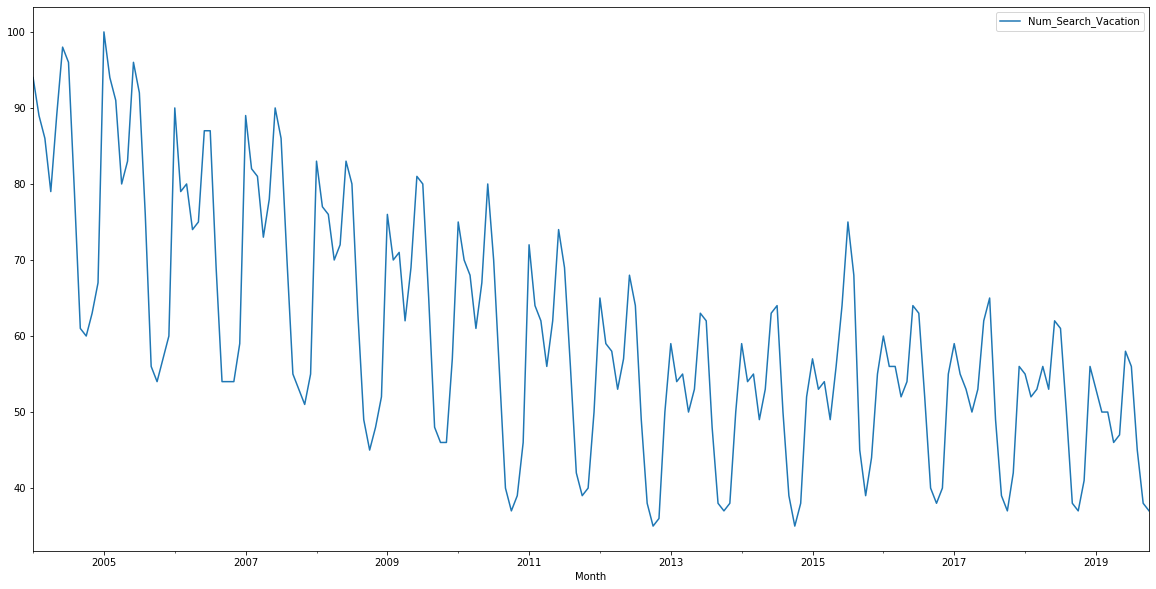

In [9]:
df.plot(figsize=(20, 10))

In [17]:
train_df = df.head(-12)
test_df = df.tail(12)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/luq/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/luq/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Prophet MSE: 38.57715797853809


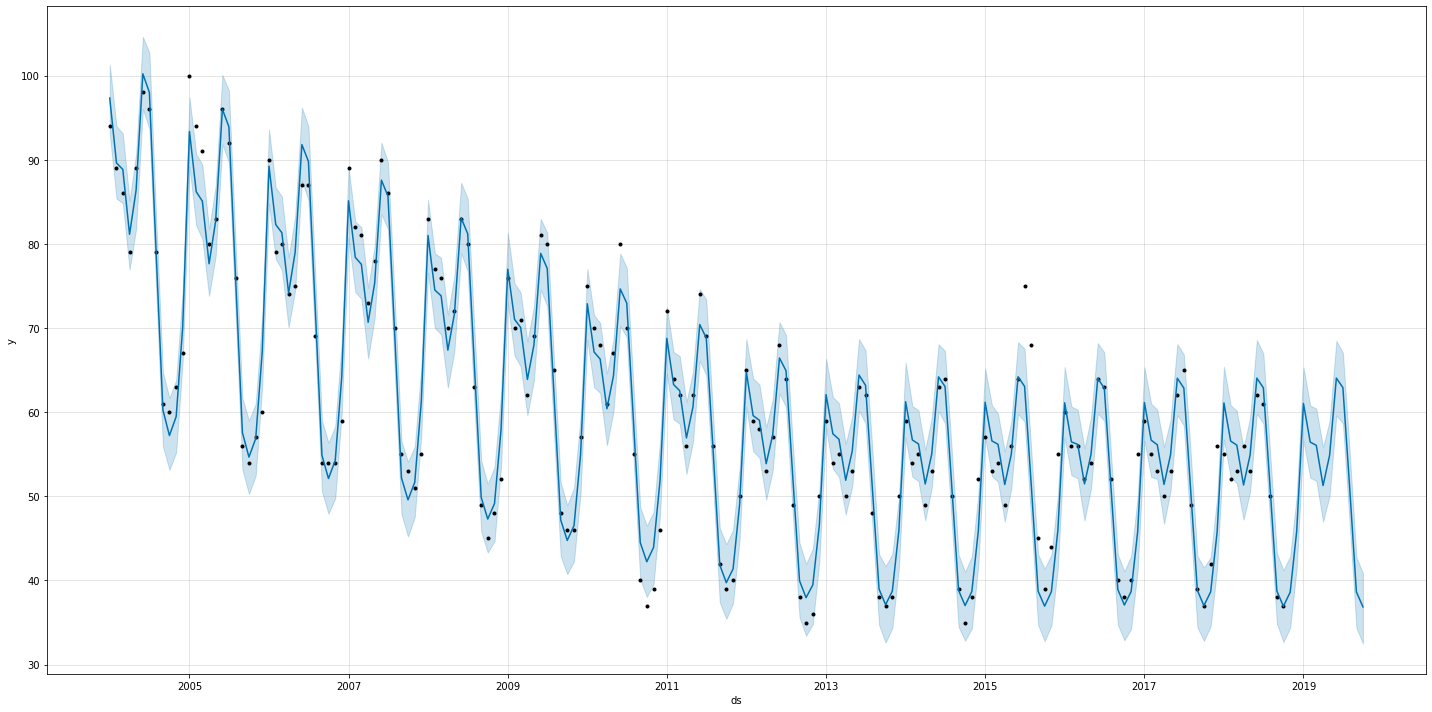

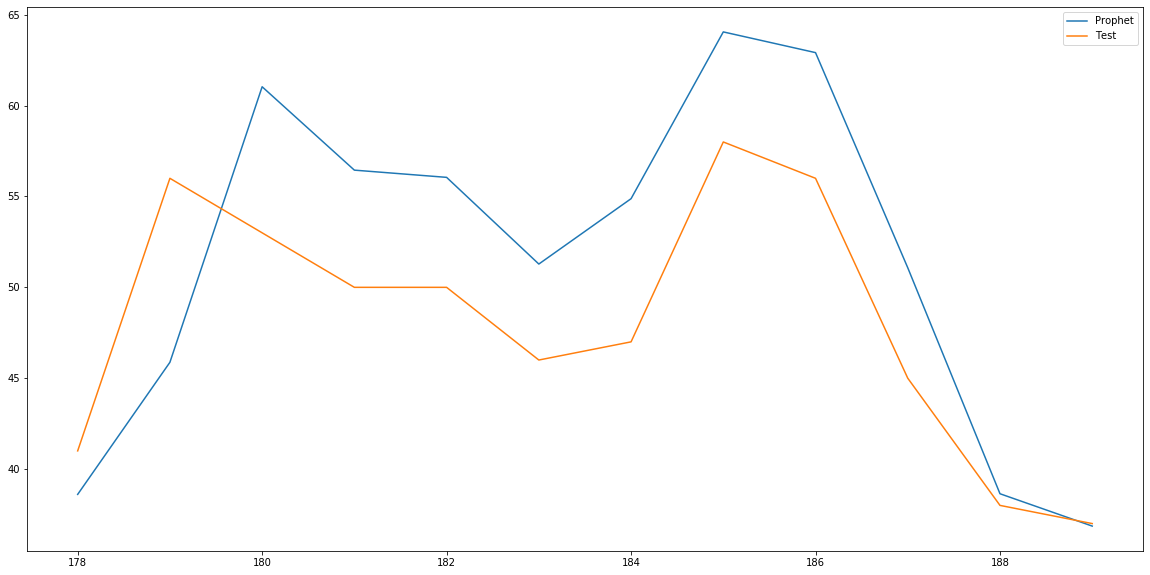

In [34]:
# Prophet
prophet_df = pd.DataFrame()
prophet_df["ds"] = df.index
prophet_df["y"] = df.values

train_prophet = prophet_df[:-12]
test_prophet = prophet_df[-12:]

prophet = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
prophet.fit(train_prophet)

future = prophet.make_future_dataframe(periods=12, freq="MS")
forecast = prophet.predict(future)

prophet.plot(forecast, figsize=(20, 10))

plt.figure(figsize=(20, 10))
plt.plot(forecast["yhat"][-12:], label="Prophet")
plt.plot(test_prophet["y"], label="Test")
plt.legend()

print(f"Prophet MSE: {mean_squared_error(test_prophet['y'], forecast['yhat'][-12:])}")


In [26]:
# SARIMA

sarima_model = pmd.auto_arima(
    train_df,
    test="adf",
    max_p=5,
    max_q=5,
    m=12,
    start_P=0,
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1159.632, Time=2.50 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1486.090, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.72 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1221.452, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1982.008, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1283.700, Time=0.68 sec
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.46 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=1097.220, Time=5.59 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=6.86 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=1095.228, Time=2.97 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=1158.317, Time=1.19 sec
 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=1001.816, Time=5.39 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=951.877, Time=2.71 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=951.276, Time=2.22 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept  

SARIMA MSE: 15.885007735007862


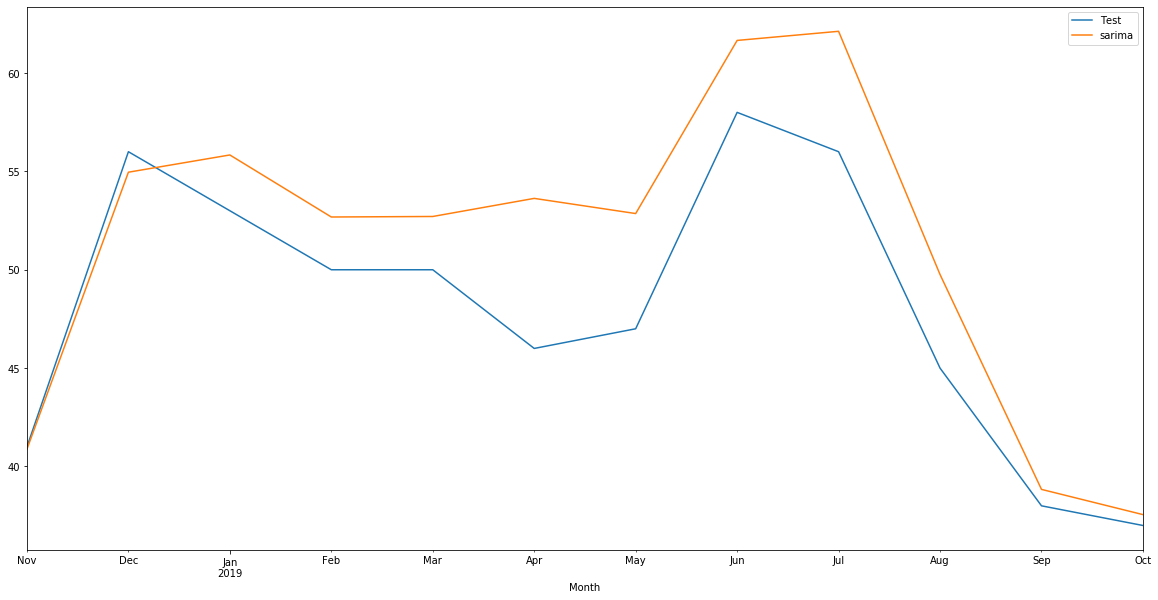

In [31]:
sarima_forecast = sarima_model.predict(n_periods=12)
sarima_df = pd.Series(sarima_forecast, index=test_df.index)
ax = test_df.plot(figsize=(20, 10))
sarima_df.plot(ax=ax)
plt.legend(["Test", "sarima"])
print(f"SARIMA MSE: {mean_squared_error(test_df.values, sarima_df.values)}")

/home/luq/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/luq/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/home/luq/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/luq/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/luq/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/luq/.local/lib/python3.6/site-packages/statsmodels/tsa/base/t

MSE for add add: 4.952413256074299
MSE for add mul: 12.611197918178071
MSE for mul add: 6.146151069320969
MSE for mul mul: 13.506404336114755


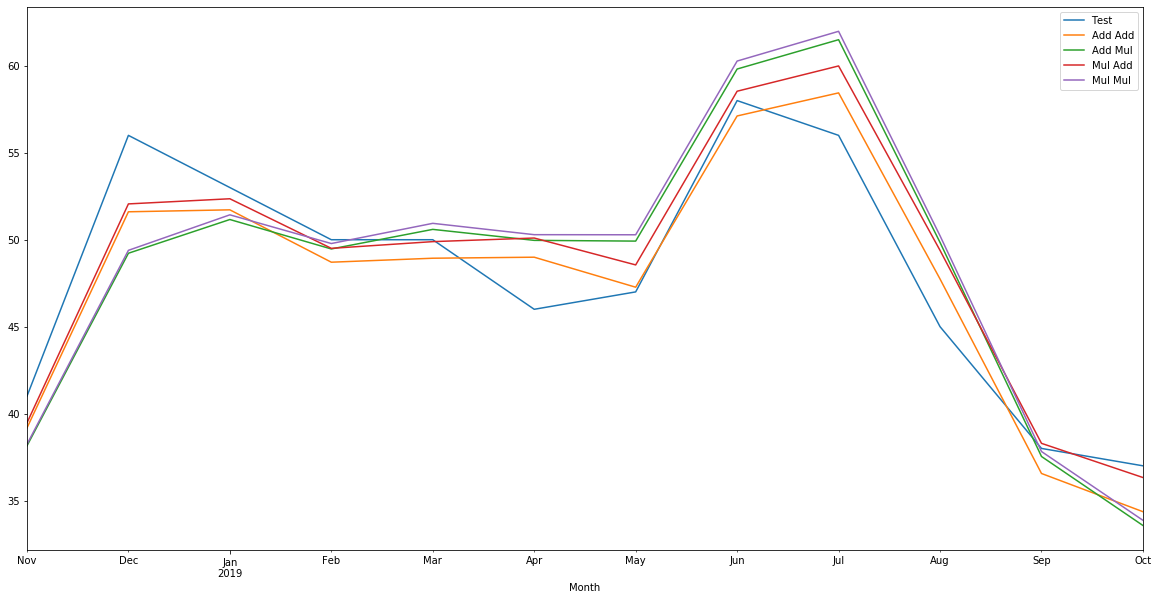

In [32]:
# Holt-Winters

fit1 = ExponentialSmoothing(train_df, trend="add", seasonal="add",).fit()
fit2 = ExponentialSmoothing(train_df, trend="add", seasonal="mul",).fit()
fit3 = ExponentialSmoothing(train_df, trend="mul", seasonal="add",).fit()
fit4 = ExponentialSmoothing(train_df, trend="mul", seasonal="mul",).fit()

fcast1 = fit1.forecast(12)
fcast2 = fit2.forecast(12)
fcast3 = fit3.forecast(12)
fcast4 = fit4.forecast(12)

ax = test_df.plot(figsize=(20,10))
fcast1.plot(ax=ax)
fcast2.plot(ax=ax)
fcast3.plot(ax=ax)
fcast4.plot(ax=ax)
ax.legend(["Test", "Add Add", "Add Mul", "Mul Add", "Mul Mul"])

mse1 = mean_squared_error(test_df, fcast1)
mse2 = mean_squared_error(test_df, fcast2)
mse3 = mean_squared_error(test_df, fcast3)
mse4 = mean_squared_error(test_df, fcast4)
print(f"MSE for add add: {mse1}")
print(f"MSE for add mul: {mse2}")
print(f"MSE for mul add: {mse3}")
print(f"MSE for mul mul: {mse4}")